    Ben Christensen
    Math 323
    2/27/18

Code gradient descent methods and use them to solve linear and logistic regression problems.

In [1]:
from scipy import optimize as opt
import numpy as np
import sympy as sy
from scipy import linalg as la
from matplotlib import pyplot as plt

In [2]:
# Problem 1
def steepest_descent(f, Df, x0, maxiter=100, tol=1e-5):
    """Compute the minimizer of f using the exact method of steepest descent.

    Parameters:
        f (function): The objective function. Accepts a NumPy array of shape
            (n,) and returns a float.
        Df (function): The first derivative of f. Accepts and returns a NumPy
            array of shape (n,).
        x0 ((n,) ndarray): The initial guess.
        maxiter (int): The maximum number of iterations to compute.
        tol (float): The stopping tolerance.

    Returns:
        ((n,) ndarray): The approximate minimum of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """

    xk = x0
    #Create function to minimize
    g = lambda a: f(xk - a*Df(xk).T)
    converged = False
    iters = 0
    #Implement steepest descent
    for k in range(maxiter):
        #Save the derivative of xk so we only have to calculate it once
        first_deriv = Df(xk)
        #Find the descent-step that minimizes the function f
        ak = opt.minimize_scalar(g).x
        xk = xk - ak * first_deriv.T
        iters += 1
        #Break if slope at xk is small enough
        if np.max(np.abs(first_deriv)) < tol:
            converged = True
            break

    return xk, converged, iters


# Problem 2
def conjugate_gradient(Q, b, x0, tol=1e-4):
    """Solve the linear system Qx = b with the conjugate gradient algorithm.

    Parameters:
        Q ((n,n) ndarray): A positive-definite square matrix.
        b ((n, ) ndarray): The right-hand side of the linear system.
        x0 ((n,) ndarray): An initial guess for the solution to Qx = b.
        tol (float): The convergence tolerance.

    Returns:
        ((n,) ndarray): The solution to the linear system Qx = b.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    n = len(b)
    rk = (Q @ x0) - b
    dk = -rk
    iters = 0
    xk = x0
    converged = False
    #Implement Algorithm 13.1
    for i in range(n+1):
        ak = (rk @ rk) / (dk @ Q @ dk)
        xk1 = xk + ak*dk
        rk1 = rk + ak*(Q @ dk)
        Bk1 = (rk1 @ rk1) / (rk @ rk)
        dk1 = -rk1 + Bk1*dk
        iters += 1
        if la.norm(rk1) < tol:
            converged = True
            break
        xk, rk, Bk, dk = xk1, rk1, Bk1, dk1

    return xk1, converged, iters



# Problem 3
def nonlinear_conjugate_gradient(f, df, x0, maxiter=100, tol=1e-5):
    """Compute the minimizer of f using the nonlinear conjugate gradient
    algorithm.

    Parameters:
        f (function): The objective function. Accepts a NumPy array of shape
            (n,) and returns a float.
        Df (function): The first derivative of f. Accepts and returns a NumPy
            array of shape (n,).
        x0 ((n,) ndarray): The initial guess.
        maxiter (int): The maximum number of iterations to compute.
        tol (float): The stopping tolerance.

    Returns:
        ((n,) ndarray): The approximate minimum of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """

    rk = -df(x0).T
    dk = rk
    xk = x0
    g = lambda a: f(xk + a*dk)
    a0 = opt.minimize_scalar(g).x
    xk = x0 + a0*dk
    iters = 1
    converged = False
    #Implement Algorithm 13.2
    while iters < maxiter:
        rk1 = -df(xk).T
        Bk = (rk1 @ rk1) / (rk @ rk)
        dk = rk1 + Bk*dk
        ak = opt.minimize_scalar(g).x
        xk1 = xk + ak*dk
        iters += 1
        if la.norm(rk1) < tol:
            converged = True
            break
        xk, rk = xk1, rk1

    return xk1, converged, iters


# Problem 4
def prob4(filename="/Users/benchristensen/Desktop/ACME Python Labs/Volume2-Student-Materials/GradientMethods/linregression.txt",
          x0=np.array([-3482258, 15, 0, -2, -1, 0, 1829])):
    """Use conjugate_gradient() to solve the linear regression problem with
    the data from the given file, the given initial guess, and the default
    tolerance. Return the solution to the corresponding Normal Equations.
    """
    data = np.loadtxt(filename)
    m,n = data.shape
    #Create matrix A
    A = np.hstack((np.ones(m).reshape(-1, 1), data[:, 1:]))
    y = data[:, 0]
    Q = A.T @ A
    b = A.T @ y
    #Solve A.T @ A = A.T @ b
    return conjugate_gradient(Q, b, x0)[0]


# Problem 5
class LogisticRegression1D:
    """Binary logistic regression classifier for one-dimensional data."""

    def fit(self, x, y, guess):
        """Choose the optimal beta values by minimizing the negative log
        likelihood function, given data and outcome labels.

        Parameters:
            x ((n,) ndarray): An array of n predictor variables.
            y ((n,) ndarray): An array of n outcome variables.
            guess (array): Initial guess for beta.
        """
        m = len(x)
        neg_log = lambda B: np.sum([np.log(1+np.exp(-(B[0] + B[1]*x[i]))) + (1 - y[i])*(B[0] + B[1]*x[i]) for i in range(m)])
        B = opt.fmin_cg(neg_log, guess, disp=False)
        self.B0, self.B1 = B[0], B[1]

    def predict(self, x):
        """Calculate the probability of an unlabeled predictor variable
        having an outcome of 1.

        Parameters:
            x (float): a predictor variable with an unknown label.
        """
        self.sigma = 1 / (1 + np.exp(-(self.B0 + self.B1 * x)))



# Problem 6
def prob6(filename="/Users/benchristensen/Desktop/ACME Python Labs/Volume2-Student-Materials/GradientMethods/challenger.npy", 
          guess=np.array([20., -1.])):
    """Return the probability of O-ring damage at 31 degrees Farenheit.
    Additionally, plot the logistic curve through the challenger data
    on the interval [30, 100].

    Parameters:
        filename (str): The file to perform logistic regression on.
                        Defaults to "challenger.npy"
        guess (array): The initial guess for beta.
                        Defaults to [20., -1.]
    """
    data = np.load(filename)
    x, y = data[:, 0], data[:, 1]
    #Instantiate Class
    Classy = LogisticRegression1D()
    Classy.fit(x, y, guess)
    domain = np.linspace(30, 100, 400)
    Classy.predict(domain)


    plt.plot(domain, Classy.sigma)
    Classy.predict(31)
    prediction = Classy.sigma
    print(prediction)
    plt.scatter(x, y, label="Previous Damage")
    plt.scatter(31, prediction, label="P(Damage) at Launch")
    plt.title("Probability of O-Ring Damage")
    plt.ylabel("O-Ring Damage")
    plt.xlabel("Temperature")
    plt.legend(loc="center right")
    plt.show()

    return prediction

In [3]:
#Testing problem 1
#Easy function
f = lambda x: x[0]**4 + x[1]**4 + x[2]**4
Df = lambda x: np.array([4*x[0]**3, 4*x[1]**3, 4*x[2]**3])
print("f(x, y, z) = x^4 + y^4 + z^4")
print("Answer:", steepest_descent(f, Df, x0 = np.array([2, 1, 2]), tol=1e-10))
#Testing the Rosenbrock function
def f(x):
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

def Df(x):
    return np.array([400*x[0]*(x[0]**2 - x[1]) + 2*x[0] - 2, -200*x[0]**2 + 200*x[1]])
print("Rosenbrock function")
print("Answer:", steepest_descent(f, Df, x0 = np.array([-2, 2]), maxiter=100000))

f(x, y, z) = x^4 + y^4 + z^4
Answer: (array([ -4.17102443e-05,  -2.08551221e-05,  -4.17102443e-05]), True, 10)
Rosenbrock function
Answer: (array([ 1.00000865,  1.00001731]), True, 17498)


In [4]:
#Testing Problem 2
Q = np.array([[2, 0], [0, 4]])
b = np.array([1, 8])
x0 = np.array([1, 3])
f = lambda x: x[0]**2 + 2*x[1]**2 - x[0] - 8*x[1]
Df = lambda x: np.array([2*x[0] - 1, 4*x[1] - 8])
print(conjugate_gradient(Q, b, x0))
print(steepest_descent(f, Df, x0))
#General test of Prob #2
n = 10
A = np.random.random((n,n))
Q = A.T @ A
b, x0 = np.random.random((2,n))
x = conjugate_gradient(Q, b, x0)[0]
print(np.allclose(Q @ x, b))

(array([ 0.5,  2. ]), True, 2)
(array([ 0.50000028,  2.00000054]), True, 8)
True


In [5]:
#Testing Problem 3
def f(x):
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

def Df(x):
    return np.array([400*x[0]*(x[0]**2 - x[1]) + 2*x[0] - 2, -200*x[0]**2 + 200*x[1]])
x0 = np.array([10, 10])
print(nonlinear_conjugate_gradient(f, Df, x0, maxiter=1000))

(array([ 0.99999711,  0.99999423]), True, 308)


In [6]:
prob4()

array([ -3.48225800e+06,   1.50167080e+01,  -3.58101458e-02,
        -2.02012486e+00,  -1.03319899e+00,  -5.11771269e-02,
         1.82915588e+03])

0.999609620514


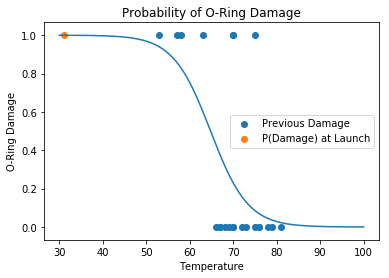

Probability of O-ring damage at 31 degrees Farenheit: 0.999609620514


In [7]:
print("Probability of O-ring damage at 31 degrees Farenheit:", prob6())